<a href="https://colab.research.google.com/github/yohanesnuwara/reservoir-engineering/blob/master/Unit%209%20Dry-Gas%20Reservoirs/notebook/9_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unit 9 Dry-Gas Reservoirs**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
!git clone https://www.github.com/yohanesnuwara/reservoir-engineering

Cloning into 'reservoir-engineering'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 811 (delta 33), reused 0 (delta 0), pack-reused 696
Receiving objects: 100% (811/811), 3.41 MiB | 29.56 MiB/s, done.
Resolving deltas: 100% (331/331), done.


## **Functions (Chapter 9.2 Volumetrics and Recovery Factors)**

In [0]:
def recovery_factor_drygas_waterdrive(swi, Bgi, sgr, Bga):
  "recovery factor of dry gas reservoir with waterdrive"
  # gas FVF at abandonment pressure (RB/scf)
  # sgr: residual gas saturation
  rf = (((1 - swi) / Bgi) - (sgr / Bga)) / ((1 - swi) / Bgi)
  return(rf)

def recovery_factor_drygas_volumetric(Bgi, Bga):
  "recovery factor of dry gas reservoir with NO waterdrive"  
  # gas FVF at abandonment pressure (RB/scf)
  # sgr: residual gas saturation
  rf = 1 - (Bgi / Bga)
  return(rf)

## **Chapter 9.3 Gas Equivalence to Condensates and Water**

It's already mentioned in book that **1 STB of condensate is equivalent with 700 to 750 scf of gas** measured at standard conditions (`T = 519.67 R; 15.6 C; 60 F` and `P = 14.7 psi; 101.325 kPa`). I'm interested to find out the **API gravity** of condensates, by re-arranging Equation 9.5, 9.6, and 9.7)

In [15]:
"Gas equivalence to condensate"

Tsc = 519.57 # standard temp in Rankine
psc = 14.7 # standard pressure in psi
R = 10.732
rho_w = 350.16 # water density in lbm/STB
V1 = 700 # the smallest value of gas equivalence (scf)
V2 = 750 # the largest value of gas equivalence (scf)

# solve for api from Equation 9.5, 9.6, 9.7
from scipy.optimize import fsolve

def f(api):
  so = 141.5 / (api + 131.5) # so: specific gravity of oil (dimensionless)
  Mo = 5854 / (api - 8.811) # molecular weight of oil
  n = (rho_w * so) / Mo
  # real gas equation: V = nRT/p
  f1 = ((n * R * Tsc) / psc) - V1
  return(f1)

api1 = fsolve(f, 40)
api1 = np.float64(api1)

def f(api):
  so = 141.5 / (api + 131.5) # so: specific gravity of oil (dimensionless)
  Mo = 5854 / (api - 8.811) # molecular weight of oil
  n = (rho_w * so) / Mo
  # real gas equation: V = nRT/p
  f2 = ((n * R * Tsc) / psc) - V2
  return(f2)

api2 = fsolve(f, 40)
api2 = np.float64(api2)

print("API gravity of condensate is between:", api1, "API and:", api2, "API")

API gravity of condensate is between: 47.93319100231802 API and: 51.57941144067795 API


In most references, the value of API for condesates is greater than this value range (50 to 80 API). For example:

<div>
<img src="https://user-images.githubusercontent.com/51282928/75760535-0335de80-5d6a-11ea-899d-a1f7fde50c80.jpg" width="500"/>
</div>

**100 STB of condensate with API gravity of 65**, is therefore equivalent to: 

In [16]:
def condensate_to_gas_equivalence(api, stb):
  "Derivation from real gas equation"
  Tsc = 519.57 # standard temp in Rankine
  psc = 14.7 # standard pressure in psi
  R = 10.732
  rho_w = 350.16 # water density in lbm/STB

  so = 141.5 / (api + 131.5) # so: specific gravity of oil (dimensionless)
  Mo = 5854 / (api - 8.811) # molecular weight of oil
  n = (rho_w * so) / Mo  

  V1stb = ((n * R * Tsc) / psc)
  V = V1stb * stb
  return(V1stb, V)

stb = 100; api = 65

V1stb, V = condensate_to_gas_equivalence(api, stb)
print("1 STB of condensate is equivalent to:", V1stb, "scf of gas.", stb, "STB of condensate is equivalent to:", V, "scf of gas")

1 STB of condensate is equivalent to: 918.0501371833875 scf of gas. 100 STB of condensate is equivalent to: 91805.01371833876 scf of gas


The gas equivalence is also simplified into a more general form (Eq 9.5)

$$V = 132849\frac{\gamma}{M}$$

$M$ is molecular weight 
* for condensate/oil, $M_o = \frac{42.43\gamma_o}{1.008-\gamma_o}$ with $\gamma_o$ is oil specific gravity; $\gamma_o = \frac{141.5}{api + 131.5}$ and $api$ is the API gravity
* for water, $M_w = 18$ and $\gamma_w = 1$

**100 STB of water**, is therefore equivalent to: 

In [17]:
stb = 100
V1stb = 132849 * (1 / 18)
V = stb * V1stb
print(stb, "STB of water is equivalent to:", V, "scf of gas")

100 STB of water is equivalent to: 738050.0 scf of gas


## **Chapter 9.4 Material-Balance Analysis of Dry-Gas Reservoirs**

General equation of material balance in dry gas reservoirs:
$$F = Gfgi \cdot Eg + \Delta W + Gfgi \cdot Bgi \cdot Efw$$

$Gfgi \cdot Bgi \cdot Efw = 0$ because gas normally has compressibility higher than water and rock. In **no waterdrive**, aquifer influx $\Delta W = 0$. The material balance becomes:

In [0]:
def matbalance_drygas_volumetric(Gp, Bg, Bgi, Gfgi):
  # no waterdrive
  right_term = Gp * Bg
  left_term = Gfgi * (Bg - Bgi)
  return(right_term, left_term) # right term = left term (balance)

$B_g = \frac{zTp_s}{pT_s}$ from Chapter 2 is subtituted into the material balance, it becomes Eq 9.15: 

$$\frac{p}{z} = \frac{pi}{zi} - \frac{pi \cdot Gp}{zi \cdot Gfgi}$$ 

Re-arranging the equation gives **estimation of OGIP**:

In [0]:
def ogip_matbalance_drygas_volumetric(Gp, p, z, pi, zi):
  # no waterdrive
  Gfgi = Gp / (1 - ((p * zi) / (pi * z)))
  return(Gfgi)

### Example 9.1 Determination of OGIP by Material-Balance

In [20]:
"Task. determine OGIP"

# known: volumetric (no waterdrive) dry gas reservoir
pi = 3000 # initial pressure, psi
temp = 190 # formation temperature, F
p_current = 2876 # current pressure after production, psia
Gp = 384 # gas production, MMscf
pc = 671 # critical pressure, psia
Tc = 358 # critical temperature, Rankine

# conversion
Gp = Gp * 1E+06 # from MMscf to scf

# determine gas compressibility factor z using Dranchuk-Abou Kassem EOS rather than using chart
import os, sys
sys.path.append('/content/reservoir-engineering/Unit 2 Review of Rock and Fluid Properties/functions')
from dranchuk_aboukassem import dranchuk

# convert temperature from F to Rankine
temp_conv = temp + 459.67

P_pr_initial = pi / pc
P_pr_current = p_current / pc
T_pr = temp_conv / Tc

rho_pr_initial, z_initial = dranchuk(T_pr, P_pr_initial)
rho_pr_current, z_current = dranchuk(T_pr, P_pr_current)
print("Initial gas compressibility factor:", z_initial) 
print("Current gas compressibility factor:", z_current) 

# calculate OGIP
Gfgi = ogip_matbalance_drygas_volumetric(Gp, p_current, z_current, pi, z_initial)
print("Original Gas in Place:", Gfgi / 1E+09, "Bscf")

Initial gas compressibility factor: 0.9069024150713222
Current gas compressibility factor: 0.9039322509456235
Original Gas in Place: 10.056746912653262 Bscf


## **Chapter 9.5 Material-Balance Plots to Determine OGIP**

### Plot 9.1: $G_p B_g$ vs $B_g - B_gi$
* **Straight line** indicates gas is volumetric (waterdrive is negligible). Intercept $b = 0$ and slope $m = Gfgi$
* **Curving upward** indicates waterdrive is present ($\Delta W$ is not negligible, See Chapter 9.6)
* **Curving downward** indicates that $Efg$ is not negligible and formation compressibility $ct$ is comparable with gas compressibility (See Chapter 9.7).

### Plot 9.2: $\frac{p}{z}$ vs $G_p$
* **Straight line** indicates gas is volumetric (waterdrive is negligible). Intercept $b = Gfgi$ and slope $m = \frac{p_i}{z_i \cdot Gfgi}$
* **Curving upward** indicates waterdrive is present ($\Delta W$ is not negligible, See Chapter 9.6)
* **Curving downward** indicates that $Efg$ is not negligible and formation compressibility $ct$ is comparable with gas compressibility (See Chapter 9.7).

### Example 9.2 Determination of OGIP by Material-Balance Plot

OGIP calculated using Plot 9.1: 10.748033224262944 Bscf
OGIP calculated using Plot 9.2: 10.758397571436433 Bscf


(0, 4181.1)

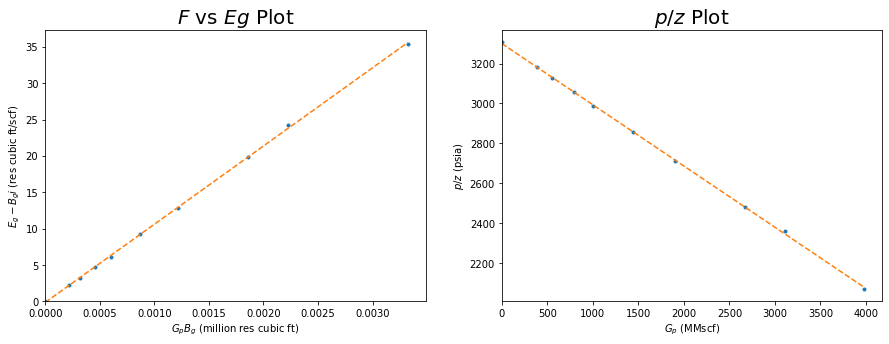

In [21]:
"Task. determine OGIP"

# known Table 9.1 
pressure = np.array([3000, 2876, 2824, 2755, 2688, 2570, 2435, 2226, 2122, 1866])
Gp = np.array([0, 384, 550, 788, 1002, 1445, 1899, 2670, 3113, 3982])

# properties similar to Example 9.1
temp = 190 + 459.67 # F to Rankine
Tc = 358
pc = 671

# calculate gas z factor and FVF
z_arr = []
Bg_arr = []
for i in range(len(pressure)):
  P_pr = pressure[i] / pc
  T_pr = temp / Tc
  rho_pr, z = dranchuk(T_pr, P_pr)
  Bg = 0.0282793 * z * temp / pressure[i] # Eq 2.2, temp in Rankine, p in psia
  z_arr.append(float(z))
  Bg_arr.append(float(Bg))

"Using Plot 9.1"
Eg = np.array(Bg_arr) - Bg_arr[0]
Gp_Bg = Gp * np.array(Bg_arr)

# regression
sys.path.append('/content/reservoir-engineering/Unit 7 Introduction to Well-Test Analysis/functions')
from regression import regression
c1, m1 = regression(Eg, Gp_Bg)

# straight line has slope m
Gfgi_plot1 = np.abs(m1)
print("OGIP calculated using Plot 9.1:", Gfgi_plot1 / 1E+03, "Bscf")

"Using Plot 9.2"
p_z = pressure / z_arr

# regression
sys.path.append('/content/reservoir-engineering/Unit 7 Introduction to Well-Test Analysis/functions')
from regression import regression
c2, m2 = regression(Gp, p_z)

# straight line has equation of: y=mx+c. Gfgi is the line intercept when y=0
Gfgi_plot2 = c2 / np.abs(m2)
print("OGIP calculated using Plot 9.2:", Gfgi_plot2 / 1E+03, "Bscf")

# Material-Balance Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(Eg, Gp_Bg, '.')
# plot regression
F_reg = m1 * Eg + c1
plt.plot(Eg, F_reg, '--')
plt.title('$F$ vs $Eg$ Plot', size=20)
plt.xlabel('$G_p B_g$ (million res cubic ft)'); plt.ylabel('$E_g-B_gi$ (res cubic ft/scf)')
plt.xlim(xmin=0); plt.ylim(ymin=0)

plt.subplot(1, 2, 2)
plt.plot(Gp, p_z, '.')
# plot regression
p_z_reg = m2 * Gp + c2
plt.plot(Gp, p_z_reg, '--')
plt.title('$p/z$ Plot', size=20)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$p/z$ (psia)')
plt.xlim(xmin=0)

## **Chapter 9.6 Waterdrive Gas Reservoirs**

### **Plot 9.3**: $\frac{F}{E_g + Bgi \cdot Efw}$ vs. $G_p$ or $t$

* If the line is **horizontal**, indicates **volumetric gas reservoir** (no waterdrive), equal to $Gfgi$.
* If the line is **sloping**, the gas reservoir has **waterdrive**

### **Plot 9.4**: $\frac{F}{E_g}$ vs. $\sum (\Delta p \cdot We_d)$ (Havlena and Odeh)

$We_d$ is calculated using **aquifer infux** in Unit 8. The slope is constant, equals to **aquifer constant, $k'$**. Intercept equals to $Gfgi$

### **Plot 9.5**: $F$ vs. $E_c$ (Sills)

Where $E_c = E_g + Bgi \cdot Efw + \frac{2(c_f + c_w)Bgi \sum (\Delta p \cdot We_d)}{1-Sw_i} \cdot (\frac{aquiferthickness}{reservoirthickness})$

$m = Gfgi$ and $intercept = 0$

### Example 9.3 Verification of Volumetric Nature of a Gas Reservoir

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Slope: 0.18826023842710268 is relatively horizontal
Intercept is OGIP: 10.130185127404664 Bscf


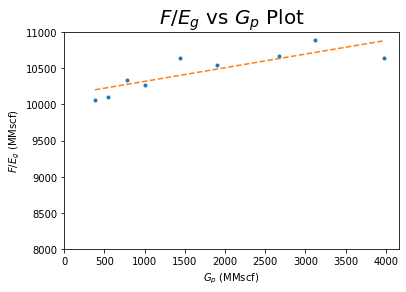

In [52]:
"Task. use Plot 9.3 to verify that reservoir in Example 9.2 is volumetric (no waterdrive)"

axisx = (np.array(Gp))[1:]
F = Gp_Bg
axisy = (np.array(F / Eg))[1:]

# regression
sys.path.append('/content/reservoir-engineering/Unit 7 Introduction to Well-Test Analysis/functions')
from regression import regression
c3, m3 = regression(axisx, axisy)
y_reg = m3 * axisx + c3

plt.plot(axisx, axisy, '.')
plt.plot(axisx, y_reg, '--')
plt.title('$F/E_g$ vs $G_p$ Plot', size=20)
plt.xlabel('$G_p$ (MMscf)'); plt.ylabel('$F/E_g$ (MMscf)')
plt.xlim(xmin=0); plt.ylim(8000, 11000)

print("Slope:", m3, "is relatively horizontal")
print("Intercept is OGIP:", c3 / 1E+03, "Bscf")

Therefore, the reservoir is most likely to be **volumetric (NO waterdrive)**

In [60]:
Bw = 1.052 # rb/stb
Wp = 0
F = 3.196244 * 1E+06 # million res bbl to rb
Gfgi = 231 * 1E+06 # bscf to mscf (thousand scf)
Eg = 0.0056 # res bbl/mscf
Bgi = 0.5404 * 0.178108 # res ft3/mscf to res bbl/mscf

cf = 3.5E-6 # psi^-1
cw = 2.9E-6 # psi^-1
swi = 0.21
Efw = ((cf + cw * swi) / (1 - swi)) * (8330 - 8323)

we = (Bw * Wp) + F - (Gfgi * Eg) - (Gfgi * Bgi * Efw)

w2 = F - (Gfgi * (Eg + (Bgi * Efw)))
print(we)
print(w2)

1901834.4981657718
1901834.4981657718
